In [10]:
# Import necessary libraries
import numpy as np
import pandas as pd
import os
import cv2
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.inspection import permutation_importance
import seaborn as sns
import shap
import lime
from lime.lime_image import LimeImageExplainer
from pathlib import Path


np.random.seed(42)
tf.random.set_seed(42)

# Define constants
DATA_DIR = "/kaggle/input/brain-tumor-mri-dataset"
TRAIN_DIR = os.path.join(DATA_DIR, "Training")
TEST_DIR = os.path.join(DATA_DIR, "Testing")
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
CLASSES = sorted([item.name for item in Path(TRAIN_DIR).iterdir() if item.is_dir()])
NUM_CLASSES = len(CLASSES)
print(f"Classes found: {CLASSES}")

Classes found: ['glioma', 'meningioma', 'notumor', 'pituitary']


In [11]:
# Set up ImageDataGenerator for training and testing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators with class_mode='sparse'
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',  # Yields integer labels
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',  # Yields integer labels
    shuffle=False
)

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [12]:
# Convert generators to tf.data.Dataset
def gen_to_dataset(generator):
    output_signature = (
        tf.TensorSpec(shape=(None, IMG_SIZE[0], IMG_SIZE[1], 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.float32)  # Integer labels
    )
    dataset = tf.data.Dataset.from_generator(
        lambda: generator,
        output_signature=output_signature
    )
    return dataset

# Create datasets and apply repeat
train_dataset = gen_to_dataset(train_generator).repeat()
test_dataset = gen_to_dataset(test_generator).repeat()

# Get labels for evaluation
y_train_encoded = train_generator.classes
y_test_encoded = test_generator.classes

# Check class distribution
class_counts = pd.Series(train_generator.classes).value_counts()
print(class_counts)

print(f"Found {train_generator.samples} training images belonging to {NUM_CLASSES} classes.")
print(f"Found {test_generator.samples} testing images belonging to {NUM_CLASSES} classes.")

2    1595
3    1457
1    1339
0    1321
Name: count, dtype: int64
Found 5712 training images belonging to 4 classes.
Found 1311 testing images belonging to 4 classes.


In [14]:
# Prepare data for SVM
def prepare_svm_data(images, labels):
    """
    Flatten and normalize images for SVM input.
    """
    X = images.reshape(len(images), -1)  # Flatten images
    scaler = MinMaxScaler()
    X = scaler.fit_transform(X)  # Normalize
    return X, labels

# Collect images and labels from train_generator

def collect_data_from_generator(generator, num_samples):
    images = []
    labels = []
    steps = num_samples // generator.batch_size + 1
    generator.reset()  # Reset generator to start
    for _ in range(steps):
        try:
            batch_images, batch_labels = next(generator)
            images.append(batch_images)
            labels.append(batch_labels)
        except StopIteration:
            break
    images = np.concatenate(images, axis=0)[:num_samples]  # Combine batches
    labels = np.concatenate(labels, axis=0)[:num_samples]  # Combine labels
    # No need for np.argmax since labels are already integers with class_mode='sparse'
    return images, labels

# Extract data for SVM (using training data)
num_train_samples = train_generator.samples
X_train_images, y_train_labels = collect_data_from_generator(train_generator, num_train_samples)

# Prepare data for SVM
X_svm, y_svm = prepare_svm_data(X_train_images, y_train_labels)
print(f"SVM data shape: {X_svm.shape}")
print(f"SVM labels shape: {y_svm.shape}")

SVM data shape: (5712, 150528)
SVM labels shape: (5712,)


In [15]:
# Apply PCA for dimensionality reduction
def apply_pca(X, n_components=50):
    """
    Reduce dimensionality using PCA and report explained variance.
    """
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)
    explained_variance = np.sum(pca.explained_variance_ratio_)
    print(f"Explained variance ratio with {n_components} components: {explained_variance:.4f}")
    return X_pca

X_pca = apply_pca(X_svm, n_components=50)
print(f"Data shape after PCA: {X_pca.shape}")

Explained variance ratio with 50 components: 0.5882
Data shape after PCA: (5712, 50)


In [16]:
# Split data for SVM
X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(
    X_pca, y_svm, train_size=0.8, random_state=42, stratify=y_svm
)

print(f"SVM Training data shape: {X_train_svm.shape}")
print(f"SVM Testing data shape: {X_test_svm.shape}")

SVM Training data shape: (4569, 50)
SVM Testing data shape: (1143, 50)


In [17]:
# Train and evaluate SVM models
def train_svm_linear(X_train, y_train, X_test, y_test):
    """
    Train and evaluate SVM with linear kernel.
    """
    svm_linear = SVC(kernel='linear', C=1.0, random_state=42)
    svm_linear.fit(X_train, y_train)
    y_pred = svm_linear.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return svm_linear, accuracy

def train_svm_rbf(X_train, y_train, X_test, y_test):
    """
    Train and evaluate SVM with RBF kernel.
    """
    svm_rbf = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
    svm_rbf.fit(X_train, y_train)
    y_pred = svm_rbf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return svm_rbf, accuracy

# Train SVM models
svm_linear, svm_linear_accuracy = train_svm_linear(X_train_svm, y_train_svm, X_test_svm, y_test_svm)
svm_rbf, svm_rbf_accuracy = train_svm_rbf(X_train_svm, y_train_svm, X_test_svm, y_test_svm)

print(f"SVM-Linear Accuracy: {svm_linear_accuracy*100:.2f}%")
print(f"SVM-RBF Accuracy: {svm_rbf_accuracy*100:.2f}%")

SVM-Linear Accuracy: 64.30%
SVM-RBF Accuracy: 69.90%


In [18]:
# Prepare data for CNN
def prepare_cnn_data(images, labels):
    """
    Prepare images and labels for CNN input (RGB images, no channel modification needed).
    """
    X_cnn = images  # Images are already in shape (num_samples, 224, 224, 3)
    y_cnn = labels
    return X_cnn, y_cnn

# Extract data for CNN (using training data)
num_train_samples = train_generator.samples
X_train_images, y_train_labels = collect_data_from_generator(train_generator, num_train_samples)

# Prepare data for CNN
X_cnn, y_cnn = prepare_cnn_data(X_train_images, y_train_labels)
print(f"CNN data shape: {X_cnn.shape}")
print(f"CNN labels shape: {y_cnn.shape}")

CNN data shape: (5712, 224, 224, 3)
CNN labels shape: (5712,)


In [19]:
# Split data for CNN
X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(
    X_cnn, y_cnn, train_size=0.8, random_state=42, stratify=y_cnn
)

print(f"CNN Training data shape: {X_train_cnn.shape}")
print(f"CNN Testing data shape: {X_test_cnn.shape}")

CNN Training data shape: (4569, 224, 224, 3)
CNN Testing data shape: (1143, 224, 224, 3)


In [20]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np

# Define the dataset creation function (simplified since labels are already integers)
def gen_to_dataset(generator):
    output_signature = (
        tf.TensorSpec(shape=(None, IMG_SIZE[0], IMG_SIZE[1], 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.float32)  # Integer labels
    )
    dataset = tf.data.Dataset.from_generator(
        lambda: generator,
        output_signature=output_signature
    )
    # Debugging: Print shapes
    def debug_shapes(images, labels):
        tf.print("Images shape:", tf.shape(images))
        tf.print("Labels shape:", tf.shape(labels))
        return images, tf.cast(labels, tf.int32)  # Ensure integer type
    dataset = dataset.map(debug_shapes, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

# Create datasets
train_dataset = gen_to_dataset(train_generator)
test_dataset = gen_to_dataset(test_generator)

# Define and train CNN model with increased capacity and regularization
def build_cnn_model(input_shape=(224, 224, 3), num_classes=4):
    inputs = layers.Input(shape=input_shape)
    
    # Branch 1: Small kernel (3x3)
    x1 = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='conv2d_branch1_1')(inputs)
    x1 = layers.BatchNormalization()(x1)
    x1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv2d_branch1_2')(x1)
    x1 = layers.MaxPooling2D((2, 2))(x1)
    x1 = layers.Dropout(0.3)(x1)
    
    # Branch 2: Larger kernel (5x5)
    x2 = layers.Conv2D(128, (5, 5), activation='relu', padding='same', name='conv2d_branch2_1')(inputs)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.Conv2D(64, (5, 5), activation='relu', padding='same', name='conv2d_branch2_2')(x2)
    x2 = layers.MaxPooling2D((2, 2))(x2)
    x2 = layers.Dropout(0.3)(x2)
    
    # Concatenate features
    x = layers.Concatenate()([x1, x2])
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = models.Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Custom callback to stop training if overfitting is detected
class OverfittingStopping(tf.keras.callbacks.Callback):
    def __init__(self, max_accuracy_gap=0.3, patience=3):
        super(OverfittingStopping, self).__init__()
        self.max_accuracy_gap = max_accuracy_gap
        self.patience = patience
        self.bad_epochs = 0
        self.best_epoch = 0
        self.best_weights = None

    def on_epoch_end(self, epoch, logs=None):
        train_acc = logs.get('accuracy')
        val_acc = logs.get('val_accuracy')
        accuracy_gap = train_acc - val_acc
        if accuracy_gap > self.max_accuracy_gap:
            self.bad_epochs += 1
            print(f"\nEpoch {epoch + 1}: Accuracy gap ({accuracy_gap:.4f}) exceeds threshold ({self.max_accuracy_gap})")
        else:
            self.bad_epochs = 0
            self.best_epoch = epoch
            self.best_weights = self.model.get_weights()

        if self.bad_epochs >= self.patience:
            print(f"\nStopping training at epoch {epoch + 1} due to persistent overfitting (accuracy gap).")
            self.model.stop_training = True
            self.model.set_weights(self.best_weights)
            print(f"Restored weights from epoch {self.best_epoch + 1}")

# Add callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        min_delta=0.01,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'best_model.keras',
        monitor='val_loss',
        save_best_only=True
    ),
    OverfittingStopping(max_accuracy_gap=0.3, patience=3),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=2,
        min_lr=0.00001
    )
]

# Build and train CNN
cnn_model = build_cnn_model(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), num_classes=NUM_CLASSES)
cnn_model.summary()

# Train the model using datasets
history = cnn_model.fit(
    train_dataset,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=test_dataset,
    validation_steps=test_generator.samples // BATCH_SIZE,
    epochs=20,
    verbose=1,
    callbacks=callbacks
)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_branch1_1 (Conv2D) │ (None, 224, 224, 128)  │          3,584 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_branch2_1 (Conv2D) │ (None, 224, 224, 128)  │          9,728 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 224, 224, 128)  │            512 │ conv2d_branch1_1[0][0] │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 224, 224, 128)  │            512 │ conv2d_branch2_1[0][0] │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_branch1_2 (Conv2D) │ (None, 224, 224, 64)   │         73,792 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_branch2_2 (Conv2D) │ (None, 224, 224, 64)   │        204,864 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 112, 112, 64)   │              0 │ conv2d_branch1_2[0][0] │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 112, 112, 64)   │              0 │ conv2d_branch2_2[0][0] │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 112, 112, 64)   │              0 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 112, 112, 64)   │              0 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 112, 112, 128)  │              0 │ dropout[0][0],         │
│                           │                        │                │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 112, 112, 32)   │         36,896 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 56, 56, 32)     │              0 │ conv2d[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 56, 56, 32)     │            128 │ max_pooling2d_2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 56, 56, 32)     │              0 │ batch_normalization_2… │
├──────────────────────

 Total params: 6,754,820 (25.77 MB)

 Trainable params: 6,754,244 (25.77 MB)

 Non-trainable params: 576 (2.25 KB)

Epoch 1/20
Images shape: [32 224 224 3]
Labels shape: [32]


I0000 00:00:1746530181.112286     107 service.cc:148] XLA service 0x7e42d4005f60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746530181.112985     107 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1746530181.113005     107 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


Images shape: [32 224 224 3]
Labels shape: [32]


I0000 00:00:1746530181.764351     107 cuda_dnn.cc:529] Loaded cuDNN version 90300


Images shape: [32 224 224 3]
Labels shape: [32]
Images shape: [32 224 224 3]
Labels shape: [32]
Images shape: [32 224 224 3]
Labels shape: [32]
Images shape: [32 224 224 3]
Labels shape: [32]


2025-05-06 11:16:34.088064: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng11{k2=1,k3=0} for conv (f32[32,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,128,224,224]{3,2,1,0}, f32[64,128,5,5]{3,2,1,0}, f32[64]{0}), window={size=5x5 pad=2_2x2_2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-05-06 11:16:34.757137: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.669177128s
Trying algorithm eng11{k2=1,k3=0} for conv (f32[32,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,128,224,224]{3,2,1,0}, f32[64,128,5,5]{3,2,1,0}, f32[64]{0}), window={size=5x5 pad=2_2x2_2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivat

  1/178 ━━━━━━━━━━━━━━━━━━━━ 2:53:14 59s/step - accuracy: 0.3125 - loss: 3.3166Images shape: [32 224 224 3]
Labels shape: [32]
  2/178 ━━━━━━━━━━━━━━━━━━━━ 1:54 649ms/step - accuracy: 0.2812 - loss: 3.9450 Images shape: [32 224 224 3]
Labels shape: [32]
  3/178 ━━━━━━━━━━━━━━━━━━━━ 1:53 649ms/step - accuracy: 0.2847 - loss: 4.3207Images shape: [32 224 224 3]
Labels shape: [32]
  4/178 ━━━━━━━━━━━━━━━━━━━━ 1:52 648ms/step - accuracy: 0.2956 - loss: 4.7255Images shape: [32 224 224 3]
Labels shape: [32]
  5/178 ━━━━━━━━━━━━━━━━━━━━ 1:52 649ms/step - accuracy: 0.3090 - loss: 4.9298Images shape: [32 224 224 3]
Labels shape: [32]
  6/178 ━━━━━━━━━━━━━━━━━━━━ 1:51 649ms/step - accuracy: 0.3182 - loss: 5.0691Images shape: [32 224 224 3]
Labels shape: [32]
  7/178 ━━━━━━━━━━━━━━━━━━━━ 1:50 648ms/step - accuracy: 0.3257 - loss: 5.1672Images shape: [32 224 224 3]
Labels shape: [32]
  8/178 ━━━━━━━━━━━━━━━━━━━━ 1:50 648ms/step - accuracy: 0.3314 - loss: 5.2320Images shape: [32 224 224 3]
Labels sh

2025-05-06 11:19:16.506177: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng11{k2=1,k3=0} for conv (f32[32,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,128,224,224]{3,2,1,0}, f32[64,128,5,5]{3,2,1,0}, f32[64]{0}), window={size=5x5 pad=2_2x2_2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-05-06 11:19:17.246156: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.740077369s
Trying algorithm eng11{k2=1,k3=0} for conv (f32[32,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,128,224,224]{3,2,1,0}, f32[64,128,5,5]{3,2,1,0}, f32[64]{0}), window={size=5x5 pad=2_2x2_2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivat

Images shape: [32 224 224 3]
Labels shape: [32]
Images shape: [32 224 224 3]
Labels shape: [32]
Images shape: [32 224 224 3]
Labels shape: [32]
Images shape: [32 224 224 3]
Labels shape: [32]
Images shape: [32 224 224 3]
Labels shape: [32]
Images shape: [32 224 224 3]
Labels shape: [32]
Images shape: [32 224 224 3]
Labels shape: [32]
Images shape: [32 224 224 3]
Labels shape: [32]
Images shape: [32 224 224 3]
Labels shape: [32]
Images shape: [32 224 224 3]
Labels shape: [32]
Images shape: [32 224 224 3]
Labels shape: [32]
Images shape: [32 224 224 3]
Labels shape: [32]
Images shape: [32 224 224 3]
Labels shape: [32]
Images shape: [32 224 224 3]
Labels shape: [32]
Images shape: [32 224 224 3]
Labels shape: [32]
Images shape: [32 224 224 3]
Labels shape: [32]
Images shape: [32 224 224 3]
Labels shape: [32]
Images shape: [32 224 224 3]
Labels shape: [32]
Images shape: [32 224 224 3]
Labels shape: [32]
Images shape: [32 224 224 3]
Labels shape: [32]
Images shape: [32 224 224 3]
Labels shap

2025-05-06 11:19:35.909608: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng36{k2=3,k3=0} for conv (f32[16,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,128,224,224]{3,2,1,0}, f32[64,128,5,5]{3,2,1,0}, f32[64]{0}), window={size=5x5 pad=2_2x2_2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-05-06 11:19:36.567398: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.657910957s
Trying algorithm eng36{k2=3,k3=0} for conv (f32[16,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,128,224,224]{3,2,1,0}, f32[64,128,5,5]{3,2,1,0}, f32[64]{0}), window={size=5x5 pad=2_2x2_2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivat

  1/178 ━━━━━━━━━━━━━━━━━━━━ 1:31:27 31s/step - accuracy: 0.6875 - loss: 3.0292Images shape: [32 224 224 3]
Labels shape: [32]
  2/178 ━━━━━━━━━━━━━━━━━━━━ 1:46 603ms/step - accuracy: 0.6250 - loss: 3.1538 Images shape: [32 224 224 3]
Labels shape: [32]
  3/178 ━━━━━━━━━━━━━━━━━━━━ 1:46 606ms/step - accuracy: 0.6042 - loss: 3.2105Images shape: [32 224 224 3]
Labels shape: [32]
  4/178 ━━━━━━━━━━━━━━━━━━━━ 1:45 606ms/step - accuracy: 0.6004 - loss: 3.2225Images shape: [32 224 224 3]
Labels shape: [32]
  5/178 ━━━━━━━━━━━━━━━━━━━━ 1:45 607ms/step - accuracy: 0.5887 - loss: 3.2301Images shape: [32 224 224 3]
Labels shape: [32]
  6/178 ━━━━━━━━━━━━━━━━━━━━ 1:44 608ms/step - accuracy: 0.5777 - loss: 3.2385Images shape: [32 224 224 3]
Labels shape: [32]
  7/178 ━━━━━━━━━━━━━━━━━━━━ 1:44 609ms/step - accuracy: 0.5680 - loss: 3.2546Images shape: [32 224 224 3]
Labels shape: [32]
  8/178 ━━━━━━━━━━━━━━━━━━━━ 1:43 609ms/step - accuracy: 0.5600 - loss: 3.2684Images shape: [32 224 224 3]
Labels sh

2025-05-06 11:21:58.667398: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng11{k2=1,k3=0} for conv (f32[31,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[31,128,224,224]{3,2,1,0}, f32[64,128,5,5]{3,2,1,0}, f32[64]{0}), window={size=5x5 pad=2_2x2_2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-05-06 11:21:59.354915: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.687694543s
Trying algorithm eng11{k2=1,k3=0} for conv (f32[31,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[31,128,224,224]{3,2,1,0}, f32[64,128,5,5]{3,2,1,0}, f32[64]{0}), window={size=5x5 pad=2_2x2_2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivat

Images shape: [32 224 224 3]
Labels shape: [32]
Images shape: [32 224 224 3]
Labels shape: [32]
Images shape: [32 224 224 3]
Labels shape: [32]
Images shape: [32 224 224 3]
Labels shape: [32]
Images shape: [32 224 224 3]
Labels shape: [32]
Images shape: [32 224 224 3]
Labels shape: [32]
Images shape: [32 224 224 3]
Labels shape: [32]
Images shape: [32 224 224 3]
Labels shape: [32]
Images shape: [32 224 224 3]
Labels shape: [32]
Images shape: [32 224 224 3]
Labels shape: [32]
Images shape: [32 224 224 3]
Labels shape: [32]
Images shape: [32 224 224 3]
Labels shape: [32]
Images shape: [32 224 224 3]
Labels shape: [32]
Images shape: [32 224 224 3]
Labels shape: [32]
Images shape: [32 224 224 3]
Labels shape: [32]
Images shape: [32 224 224 3]
Labels shape: [32]
Images shape: [32 224 224 3]
Labels shape: [32]
Images shape: [32 224 224 3]
Labels shape: [32]
Images shape: [32 224 224 3]
Labels shape: [32]
Images shape: [32 224 224 3]
Labels shape: [32]
Images shape: [32 224 224 3]
Labels shap

In [21]:
# Evaluate CNN model
test_loss, cnn_accuracy = cnn_model.evaluate(X_test_cnn, y_test_cnn, verbose=0)
print(f"CNN Accuracy: {cnn_accuracy*100:.2f}%")

# Classification Report for CNN
cnn_pred = cnn_model.predict(X_test_cnn)
cnn_pred_labels = np.argmax(cnn_pred, axis=1)
print("\nCNN Classification Report:")
print(classification_report(y_test_cnn, cnn_pred_labels, target_names=['glioma', 'meningioma', 'no_tumor', 'pituitary']))

2025-05-06 11:35:59.112303: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng11{k2=1,k3=0} for conv (f32[23,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[23,128,224,224]{3,2,1,0}, f32[64,128,5,5]{3,2,1,0}, f32[64]{0}), window={size=5x5 pad=2_2x2_2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-05-06 11:35:59.369159: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.257096009s
Trying algorithm eng11{k2=1,k3=0} for conv (f32[23,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[23,128,224,224]{3,2,1,0}, f32[64,128,5,5]{3,2,1,0}, f32[64]{0}), window={size=5x5 pad=2_2x2_2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivat

CNN Accuracy: 72.79%
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 160ms/step

CNN Classification Report:
              precision    recall  f1-score   support

      glioma       0.60      0.76      0.67       264
  meningioma       0.57      0.45      0.51       268
    no_tumor       0.94      0.87      0.90       319
   pituitary       0.77      0.80      0.79       292

    accuracy                           0.73      1143
   macro avg       0.72      0.72      0.72      1143
weighted avg       0.73      0.73      0.73      1143




Final Classification Accuracies:
SVM-Linear: 64.30%
SVM-RBF: 69.90%
CNN: 72.79%


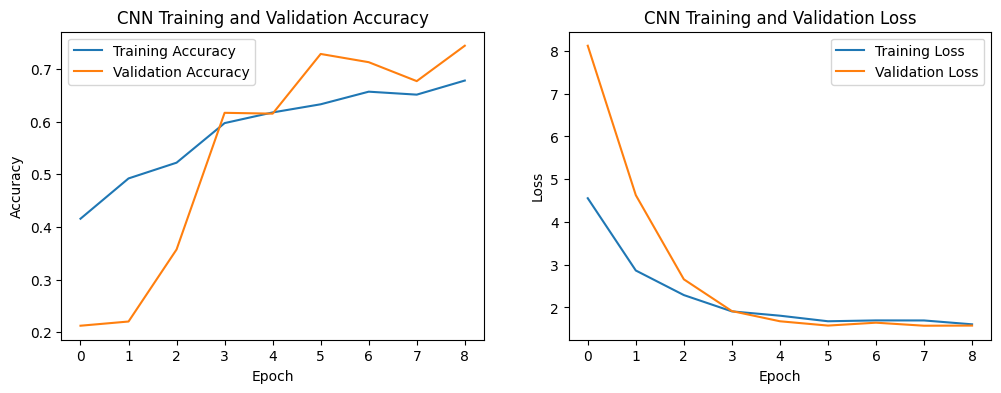

In [22]:
# Compare results
print("\nFinal Classification Accuracies:")
print(f"SVM-Linear: {svm_linear_accuracy*100:.2f}%")
print(f"SVM-RBF: {svm_rbf_accuracy*100:.2f}%")
print(f"CNN: {cnn_accuracy*100:.2f}%")

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('CNN Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step


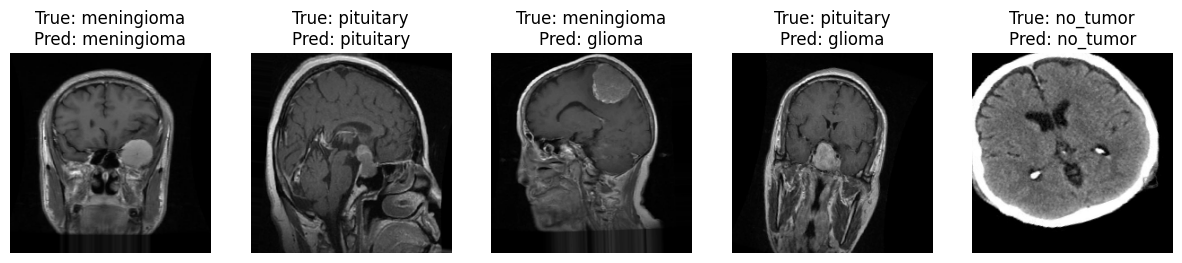

In [24]:
# Visualize sample predictions
def visualize_predictions(model, X_test, y_test, num_samples=5):
    """
    Visualize predictions for a given number of test samples.
    """
    class_names = ['glioma', 'meningioma', 'no_tumor', 'pituitary']
    predictions = model.predict(X_test)
    pred_labels = np.argmax(predictions, axis=1).astype(int)  # Convert predictions to integers
    
    plt.figure(figsize=(15, 3))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i+1)
        plt.imshow(X_test[i, :, :, 0], cmap='gray')
        plt.title(f"True: {class_names[int(y_test[i])]}\nPred: {class_names[pred_labels[i]]}")
        plt.axis('off')
    plt.show()

visualize_predictions(cnn_model, X_test_cnn, y_test_cnn, num_samples=5)

SVM-Linear Feature Importance:


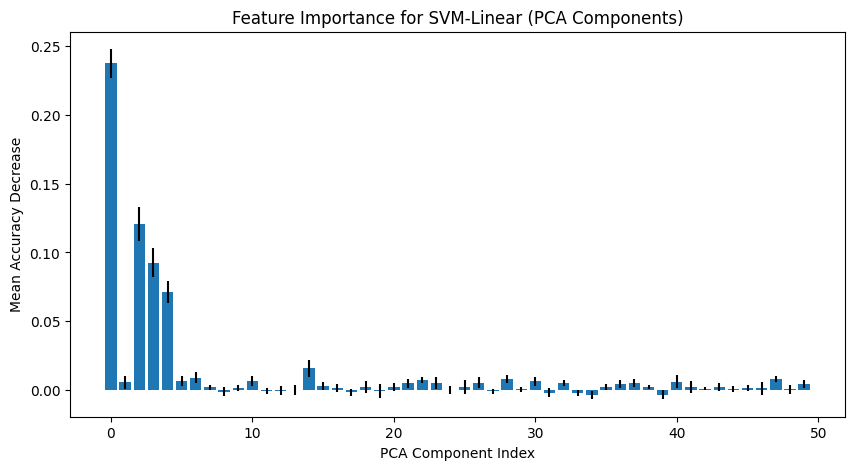

Top 5 influential PCA components for SVM-Linear:
Component 0: Importance = 0.2374 ± 0.0103
Component 2: Importance = 0.1205 ± 0.0123
Component 3: Importance = 0.0927 ± 0.0104
Component 4: Importance = 0.0715 ± 0.0080
Component 14: Importance = 0.0157 ± 0.0063

SVM-RBF Feature Importance:


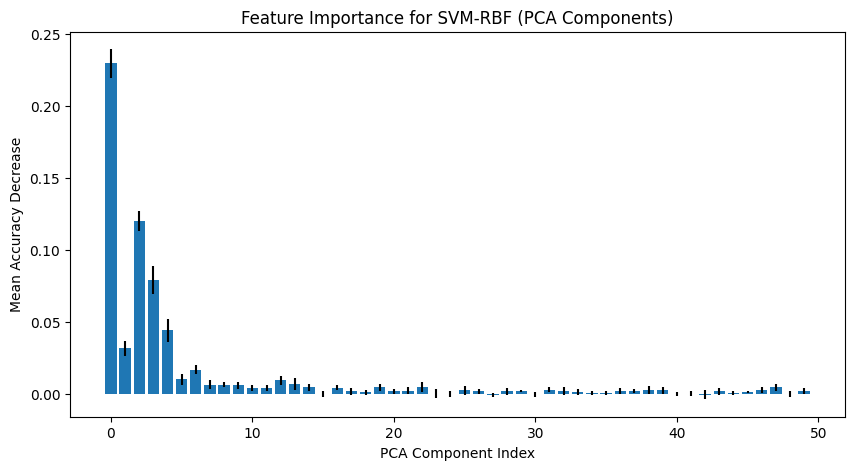

Top 5 influential PCA components for SVM-RBF:
Component 0: Importance = 0.2297 ± 0.0099
Component 2: Importance = 0.1200 ± 0.0071
Component 3: Importance = 0.0792 ± 0.0098
Component 4: Importance = 0.0442 ± 0.0081
Component 1: Importance = 0.0316 ± 0.0055


In [25]:
# Feature Importance for SVM using Permutation Importance
def compute_svm_feature_importance(model, X_test, y_test, model_name):
    """
    Compute and visualize permutation importance for SVM models.
    """
    result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
    importance_mean = result.importances_mean
    importance_std = result.importances_std
    
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(importance_mean)), importance_mean, yerr=importance_std)
    plt.title(f'Feature Importance for {model_name} (PCA Components)')
    plt.xlabel('PCA Component Index')
    plt.ylabel('Mean Accuracy Decrease')
    plt.show()
    
    top_indices = np.argsort(importance_mean)[::-1][:5]
    print(f"Top 5 influential PCA components for {model_name}:")
    for idx in top_indices:
        print(f"Component {idx}: Importance = {importance_mean[idx]:.4f} ± {importance_std[idx]:.4f}")

print("SVM-Linear Feature Importance:")
compute_svm_feature_importance(svm_linear, X_test_svm, y_test_svm, "SVM-Linear")

print("\nSVM-RBF Feature Importance:")
compute_svm_feature_importance(svm_rbf, X_test_svm, y_test_svm, "SVM-RBF")

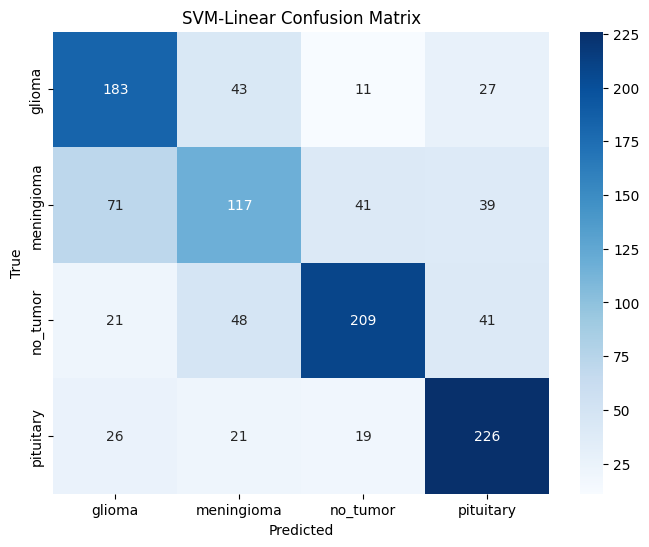

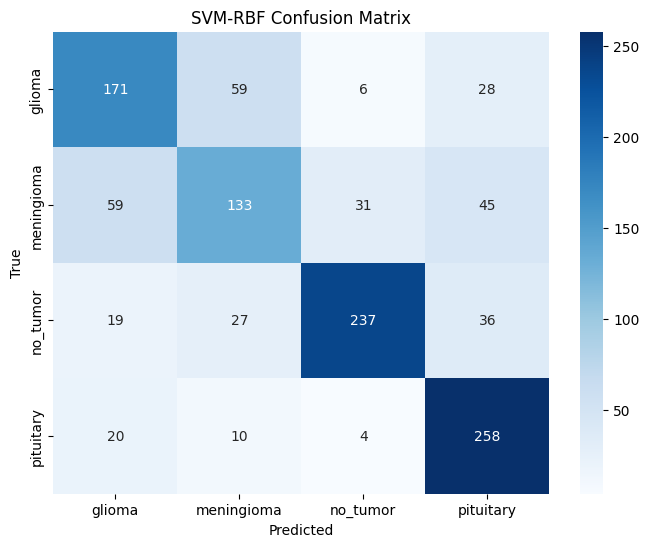

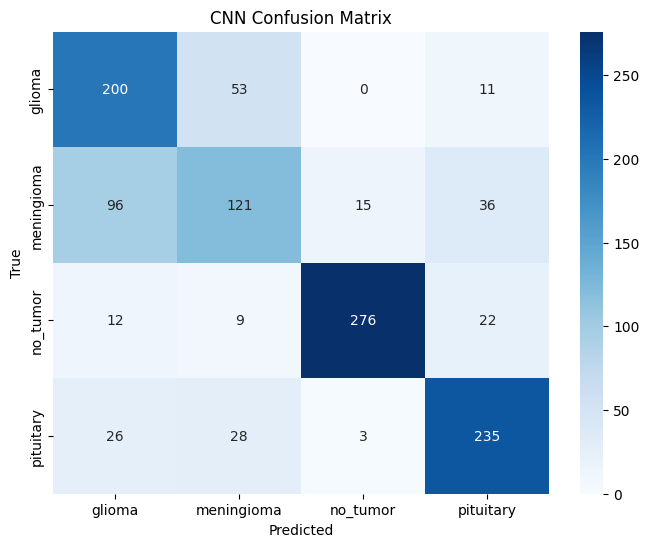

In [26]:
# Confusion Matrix for SVM and CNN
def plot_confusion_matrix(y_true, y_pred, class_names, title):
    """
    Plot confusion matrix to visualize classification performance.
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# SVM-Linear Confusion Matrix
svm_linear_pred = svm_linear.predict(X_test_svm)
plot_confusion_matrix(y_test_svm, svm_linear_pred, ['glioma', 'meningioma', 'no_tumor', 'pituitary'], "SVM-Linear Confusion Matrix")

# SVM-RBF Confusion Matrix
svm_rbf_pred = svm_rbf.predict(X_test_svm)
plot_confusion_matrix(y_test_svm, svm_rbf_pred, ['glioma', 'meningioma', 'no_tumor', 'pituitary'], "SVM-RBF Confusion Matrix")

# CNN Confusion Matrix
plot_confusion_matrix(y_test_cnn, cnn_pred_labels, ['glioma', 'meningioma', 'no_tumor', 'pituitary'], "CNN Confusion Matrix")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Sample 1 - Predicted: meningioma, True: meningioma


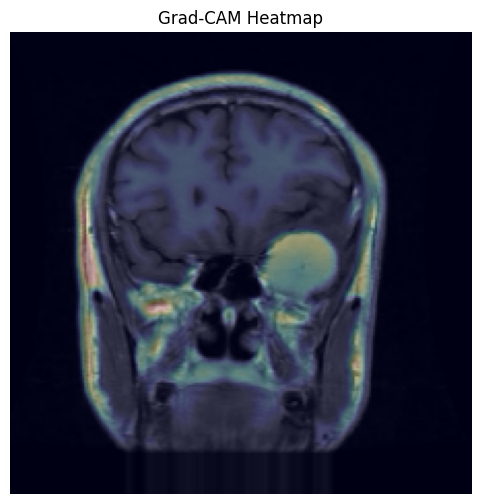

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Sample 2 - Predicted: pituitary, True: pituitary


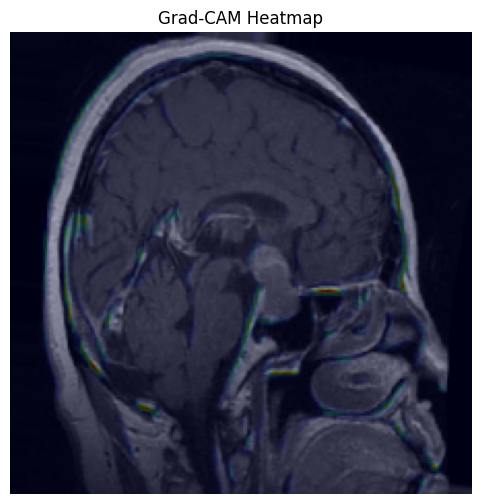

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Sample 3 - Predicted: glioma, True: meningioma


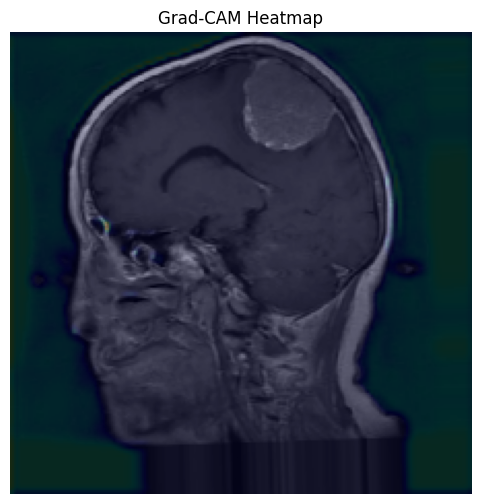

In [28]:
# Grad-CAM for CNN
def get_gradcam_heatmap(model, img_array, last_conv_layer_name, pred_index=None):
    """
    Generate Grad-CAM heatmap for a given image using the specified convolutional layer.
    """
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        loss = predictions[:, pred_index]
    
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img, heatmap, alpha=0.4):
    """
    Overlay Grad-CAM heatmap on the original image.
    """
    img = img.squeeze()
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    superimposed_img = heatmap * alpha + img * 255 * (1 - alpha)
    superimposed_img = np.clip(superimposed_img, 0, 255).astype(np.uint8)
    
    plt.figure(figsize=(6, 6))
    plt.imshow(img, cmap='gray')
    plt.imshow(superimposed_img, alpha=alpha)
    plt.title('Grad-CAM Heatmap')
    plt.axis('off')
    plt.show()

# Use the correct last convolutional layer name
last_conv_layer_name = 'conv2d'  # Last Conv2D layer after Concatenate
class_names = ['glioma', 'meningioma', 'no_tumor', 'pituitary']
for i in range(3):
    img = X_test_cnn[i:i+1]  # Shape: (1, 224, 224, 3)
    pred = cnn_model.predict(img)
    pred_label = np.argmax(pred, axis=1)[0]
    heatmap = get_gradcam_heatmap(cnn_model, img, last_conv_layer_name, pred_label)
    print(f"Sample {i+1} - Predicted: {class_names[pred_label]}, True: {class_names[int(y_test_cnn[i])]}")
    display_gradcam(img, heatmap)